In [1]:
from IPython.display import HTML
HTML('''
<script>
code_show=false;
function code_toggle(){
    if(code_show){$('.prompt, .input, .output_stderr, .output_error').hide();}
    else{$('.input, .prompt, .output_stderr, .output_error').show();}
    code_show=!code_show;
}
function initialize(){
    document.body.style.fontFamily='Palatino';
    var output=$('.output_subarea.output_text.output_stream.output_stdout');
    $.merge(output,$('.output_subarea.output_text.output_result'));
    for(var i=0;i<output.length;i++)for(var j=0;j<output[i].children.length;j++)
        output[i].children[j].style.fontFamily='Palatino';
    code_toggle();
}
$(document).ready(initialize);
</script>
Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook.
''')

# Section 1: Packages

Here we import all packages that we need.

In [349]:
%config InlineBackend.figure_format = 'retina'

import os
import sys
import warnings

if sys.platform == "darwin":
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import json
import time
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib as mpl
from sklearn.svm import SVC
from functools import reduce
from itertools import product
from collections import Counter
from xgboost import XGBClassifier
from urllib.request import urlopen
from matplotlib import pyplot as plt
from keras.optimizers import Adadelta
from imblearn.combine import SMOTETomek
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from multiprocessing import set_start_method
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential, load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap as cmap
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
                             VotingClassifier, RandomForestClassifier, AdaBoostClassifier

plt.rcParams.update(mpl.rcParamsDefault)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.facecolor'] = 'f4f4f4'
plt.rcParams['font.family'] = 'Palatino'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['lines.linewidth'] = 2
pd.options.display.max_rows = 20
warnings.filterwarnings('ignore')

# Section 2: Functions

Shorthand functions are here defined.

In [4]:
def yahoo_parser(url):
    response = urlopen(url)
    data = json.loads(response.read().decode("utf-8"))['chart']['result'][0]
    t = pd.to_datetime(data['timestamp'], unit='s').date
    c = data['indicators']['quote'][0]['close']
    return pd.DataFrame({'close': c}, index=t)


def default_parser(url):
    return pd.read_csv(url, index_col=0, parse_dates=True)


def retrieve(source, code, label, column=None):
    query = {
        'fred': 'https://fred.stlouisfed.org/graph/fredgraph.csv?id={}',
        'yahoo': 'https://query1.finance.yahoo.com/v8/finance/chart/{}?period1=500000000&period2=2000000000&interval=1d',
        'quandl': 'https://www.quandl.com/api/v3/datasets/{}.csv?api_key=ZtDUGt7_qj48rgupCAid',
        'worldbank': 'http://api.worldbank.org/v2/en/indicator/{}?downloadformat=csv',
        'csv': '{}.csv',
    }
    parser = {
        'yahoo': yahoo_parser,
    }
    url = query.get(source).format(code)
    df = parser.get(source, default_parser)(url)
    df.index.name = None
    df.columns = [col.lower() for col in df.columns] if df.shape[1] > 1 else [label]
    if not column: column = df.columns
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')[column].squeeze()


def new_feature(val, name):
    val.name = name
    return val


class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=10, impute=True, impute_strategy='median'):
        self.thresh = thresh
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh):
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with VIF={max_vif}' + ' ' * 50, end='\r')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        print(f'Final VIF={max_vif}' + ' ' * 100)
        return X


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), ha="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Section 3: Data Preparation

In [5]:
bd = retrieve('fred', 'BAMLC0A1CAAAEY', 'bd')   # bond yield
tr10 = retrieve('fred', 'DGS10', 'tr10')        # 10-year treasury
tr2 = retrieve('fred', 'DGS2', 'tr2')           # 2-year treasury
sp500 = retrieve('yahoo', '^GSPC', 'sp500')     # S&P 500 close
vix = retrieve('yahoo', '^VIX', 'vix')          # VIX close
dr = retrieve('csv', 'DR', 'dr')                # default rate
d2g = retrieve('csv', 'D2G', 'd2g')             # debt to GDP
ip = retrieve('fred', 'A091RC1Q027SBEA', 'ip')  # interest payment
rf = retrieve('fred', 'INTDSRUSM193N', 'rf')    # interest rate
gdp = retrieve('fred', 'GDP', 'gdp')            # GDP
spdr = retrieve('csv', 'SP500DR', 'spdr')       # weighted default risk of S&P 500
skew = retrieve('csv', 'SKEW', 'skew')          # CBOE SKEW index
unem = retrieve('fred', 'LNS14000024', 'unem')  # unemployment rate

In [ ]:
# create dataframe
i2g = new_feature(ip / gdp, 'i2g')                        # interest payment (% gdp)
cs = new_feature(bd - tr10, 'cs')                         # credit spread
dcs = new_feature(cs.diff(), 'dcs')                       # 1st order difference of cs
ecs = new_feature((rf + dr) / (1 - dr) - rf, 'ecs')       # estimated cs
edcs = new_feature(ecs.diff(), 'edcs')                    # estimated dcs
spr = new_feature(sp500 / sp500.shift(20) - 1, 'spr')     # sp500 monthly return
syc = new_feature(tr10 - tr2, 'syc')                      # slope of yield curve
dunem = new_feature(unem.diff(), 'dunem')                 # 1st order difference of unem

In [490]:
# assemble features
df = bd.to_frame().join([
    tr10, spr, vix,
    dr, d2g, i2g,
    # spdr, skew,    # these two variables are only available 2013 through 2019 -- too few data points
    cs, ecs, dcs, edcs,
    syc, unem, dunem]).fillna(method='ffill').dropna()
df

,bd,tr10,spr,vix,dr,d2g,i2g,cs,ecs,dcs,edcs,syc,unem,dunem
1997-01-01,6.72,6.43,0.015686,20.920000,2.064329,43.958801,0.043310,0.29,-11.637353,0.00,-0.025847,0.55,4.6,-0.1
1997-01-02,6.80,6.54,0.011487,21.139999,2.059427,43.958801,0.043310,0.26,-11.663439,-0.03,-0.026086,0.57,4.6,0.0
1997-01-03,6.80,6.52,0.026611,19.129999,2.054525,43.958801,0.043310,0.28,-11.689767,0.02,-0.026328,0.57,4.6,0.0
1997-01-04,6.80,6.52,0.026611,19.129999,2.049622,43.958801,0.043310,0.28,-11.716342,0.00,-0.026574,0.57,4.6,0.0
1997-01-05,6.80,6.52,0.037518,19.129999,2.044720,43.958801,0.043310,0.28,-11.743166,0.00,-0.026824,0.57,4.6,0.0
1997-01-06,6.80,6.54,0.029764,19.889999,2.039818,43.958801,0.043310,0.26,-11.770242,-0.02,-0.027077,0.57,4.6,0.0
1997-01-07,6.82,6.57,0.029650,19.350000,2.034915,43.958801,0.043310,0.25,-11.797575,-0.01,-0.027333,0.59,4.6,0.0
1997-01-08,6.84,6.60,0.003553,20.240000,2.030013,43.958801,0.043310,0.24,-11.825169,-0.01,-0.027593,0.59,4.6,0.0
1997-01-09,6.81,6.52,0.007985,20.910000,2.025111,43.958801,0.043310,0.29,-11.853026,0.05,-0.027857,0.58,4.6,0.0
1997-01-10,6.90,6.63,0.014195,19.629999,2.020208,43.958801,0.043310,0.27,-11.881151,-0.02,-0.028125,0.57,4.6,0.0


In [491]:
max_len = 8000  # maximum length of whole dataset
forecast = 1    # forecast the direction of dcs in n days
nlags = 3       # maximum number of lags for lagged terms

In [492]:
print('Features before lagging: {} in total'.format(df.shape[1]))
print(df.columns.tolist())

# add lagged terms
for col in df.columns:
    for i in range(1, nlags + 1):
        col_name = col + ('_L' + str(i))
        col_val = df[col].shift(i)
        df[col_name] = col_val

print('—' * 50)
print('Features including lagged variables: {} in total'.format(df.shape[1]))
print(df.columns.tolist())
        
# add 2nd-order terms
for col in df.columns:
    col_name = col + ('_2')
    col_val = df[col]**2
    df[col_name] = col_val

cat = lambda x: int(x > 0)
df['y'] = np.vectorize(cat)(df['dcs'].shift(-forecast))  # y = 1 if tmr's dcs is positive
df.reindex(sorted(df.columns.tolist()), axis=0)
idx = df.index
print('—' * 50)
print('Features including 2nd-order variables: {} in total'.format(df.shape[1] - 1))
print(df.columns.tolist()[:-1])
print('—' * 50)

# sovle colinearity by VIF reduction
rv = ReduceVIF(thresh=5)
keep_cols = ['y']
df_ = rv.fit_transform(df[[col for col in df.columns if col not in keep_cols]])
df_.index = idx
df = df_.join(df[keep_cols])

# drop nan, then truncate to max_len
df = df.replace({np.inf: np.nan, -np.inf: np.nan}).dropna().iloc[-max_len:, :]
mask = (df.std() < 1e-10)  # drop constant variables
df = df.loc[:, ~mask]
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: x / x.std())
print('—' * 50)
print('Features after reduction: {} in total'.format(df.shape[1] - 1))
print(df.columns.tolist()[:-1])

df.reindex(sorted(df.columns.tolist()[:-1]) + ['y'], axis=0)
df.describe().round(4).loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].T

Features before lagging: 14 in total
['bd', 'tr10', 'spr', 'vix', 'dr', 'd2g', 'i2g', 'cs', 'ecs', 'dcs', 'edcs', 'syc', 'unem', 'dunem']
——————————————————————————————————————————————————
Features including lagged variables: 56 in total
['bd', 'tr10', 'spr', 'vix', 'dr', 'd2g', 'i2g', 'cs', 'ecs', 'dcs', 'edcs', 'syc', 'unem', 'dunem', 'bd_L1', 'bd_L2', 'bd_L3', 'tr10_L1', 'tr10_L2', 'tr10_L3', 'spr_L1', 'spr_L2', 'spr_L3', 'vix_L1', 'vix_L2', 'vix_L3', 'dr_L1', 'dr_L2', 'dr_L3', 'd2g_L1', 'd2g_L2', 'd2g_L3', 'i2g_L1', 'i2g_L2', 'i2g_L3', 'cs_L1', 'cs_L2', 'cs_L3', 'ecs_L1', 'ecs_L2', 'ecs_L3', 'dcs_L1', 'dcs_L2', 'dcs_L3', 'edcs_L1', 'edcs_L2', 'edcs_L3', 'syc_L1', 'syc_L2', 'syc_L3', 'unem_L1', 'unem_L2', 'unem_L3', 'dunem_L1', 'dunem_L2', 'dunem_L3']
——————————————————————————————————————————————————
Features including 2nd-order variables: 112 in total
['bd', 'tr10', 'spr', 'vix', 'dr', 'd2g', 'i2g', 'cs', 'ecs', 'dcs', 'edcs', 'syc', 'unem', 'dunem', 'bd_L1', 'bd_L2', 'bd_L3', 'tr

,mean,std,min,25%,50%,75%,max
spr,0.1020,1.0000,-7.3966,-0.3922,0.1924,0.6752,5.7062
dcs,0.0012,1.0000,-41.9661,-0.2836,0.0000,0.2836,43.3839
edcs,0.0043,1.0000,-32.6955,-0.0064,-0.0011,0.0057,32.7745
dunem,0.0401,1.0000,-15.2879,0.0000,0.0000,0.0000,15.2879
spr_L3,0.1012,1.0000,-7.3933,-0.3930,0.1921,0.6749,5.7036
dcs_L1,0.0012,1.0000,-41.9661,-0.2836,0.0000,0.2836,43.3839
dcs_L2,0.0012,1.0000,-41.9663,-0.2836,0.0000,0.2836,43.3841
dcs_L3,0.0011,1.0000,-41.9630,-0.2835,0.0000,0.2835,43.3806
edcs_L1,0.0043,1.0000,-32.6955,-0.0064,-0.0011,0.0057,32.7745
edcs_L2,0.0043,1.0000,-32.6955,-0.0065,-0.0011,0.0057,32.7745


# Section 4: Feature Engineering

In [493]:
max_features = 15

#### Generate `X` and `y`.

In [494]:
X = df.drop('y', axis=1)
y = df.y
print(X.columns.tolist())

['spr', 'dcs', 'edcs', 'dunem', 'spr_L3', 'dcs_L1', 'dcs_L2', 'dcs_L3', 'edcs_L1', 'edcs_L2', 'edcs_L3', 'dunem_L1', 'dunem_L2', 'dunem_L3', 'tr10_2', 'spr_2', 'dr_2', 'd2g_2', 'dcs_2', 'edcs_2', 'dunem_2', 'spr_L3_2', 'cs_L3_2', 'dcs_L1_2', 'dcs_L2_2', 'dcs_L3_2', 'edcs_L1_2', 'edcs_L2_2', 'edcs_L3_2', 'syc_L3_2', 'dunem_L1_2', 'dunem_L2_2', 'dunem_L3_2']


#### Random Forest.

In [495]:
model = RandomForestClassifier(random_state=0)
model.fit(X, y)
feature_imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
feat_imp = feature_imp.sort_values('importance', ascending=False).head(max_features).index.tolist()
print(feat_imp)
feat_imp = pd.DataFrame({'rank_imp': np.arange(max_features)}, index=feat_imp).T

['spr_L3_2', 'tr10_2', 'spr_L3', 'spr', 'spr_2', 'dr_2', 'syc_L3_2', 'cs_L3_2', 'edcs_L1', 'edcs', 'edcs_L2', 'edcs_L3', 'dcs', 'dcs_L1', 'edcs_L3_2']


#### $\chi^2$ Test.

In [496]:
X_minmax = MinMaxScaler([0, 1]).fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
feature_scoring = pd.DataFrame({'feature': X.columns,'score': X_scored.scores_})
feat_scored = feature_scoring.sort_values('score', ascending=False).head(max_features)['feature'].values.tolist()
print(feat_scored)
feat_scored = pd.DataFrame({'rank_scored': np.arange(max_features)}, index=feat_scored).T

['dunem_L3_2', 'edcs_L2_2', 'spr_L3_2', 'dr_2', 'syc_L3_2', 'dunem_L2_2', 'dcs_L3_2', 'dunem_L1_2', 'dcs_L1_2', 'dcs_2', 'spr_2', 'edcs_2', 'dunem_2', 'spr', 'd2g_2']


#### Recursive Feature Elimination (RFE)

with Logistic Regression model.

In [497]:
rfe = RFE(LogisticRegression(), max_features)
rfe.fit(X, y)
feature_rfe_scoring = pd.DataFrame({'feature': X.columns,'score': rfe.ranking_})
feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score']==1]['feature'].values.tolist()
print(feat_rfe)
feat_rfe = pd.DataFrame({'rank_rfe': np.arange(max_features)}, index=feat_rfe).T

['spr', 'spr_L3', 'dcs_L2', 'dcs_L3', 'edcs_L1', 'edcs_L2', 'dr_2', 'spr_L3_2', 'cs_L3_2', 'dcs_L3_2', 'edcs_L1_2', 'edcs_L2_2', 'edcs_L3_2', 'syc_L3_2', 'dunem_L3_2']


#### Final Selection of Features

is the features that have the smallest sum of ranks above.

In [498]:
features = pd.concat([feat_imp, feat_scored, feat_rfe]).fillna(max_features).\
           sum().sort_values().index[:max_features].tolist()
features.sort()
print('Final features: {} in total'.format(len(features)))
print(features)

Final features: 15 in total
['cs_L3_2', 'dcs_L2', 'dcs_L3', 'dcs_L3_2', 'dr_2', 'dunem_L3_2', 'edcs_L1', 'edcs_L2', 'edcs_L2_2', 'spr', 'spr_2', 'spr_L3', 'spr_L3_2', 'syc_L3_2', 'tr10_2']


In [574]:
df_model = df.loc[:, features + ['y']]
df_model.to_csv('df_model.csv', header=True)
X = df_model.drop('y', axis=1).values
y = df_model.y.values

In [500]:
# df_ = pd.DataFrame(np.vstack([X.T, y]).T, columns=df_model.columns)
# sns.pairplot(df_, vars=df_.columns, hue='y', palette={0:'r', 1:'k'}, height=3, plot_kws={'edgecolor': 'none'})
# plt.show()

# Section 5: Model Training

#### Prepare data for training

(8630, 15) (8630,)
(2140, 15) (2140,)


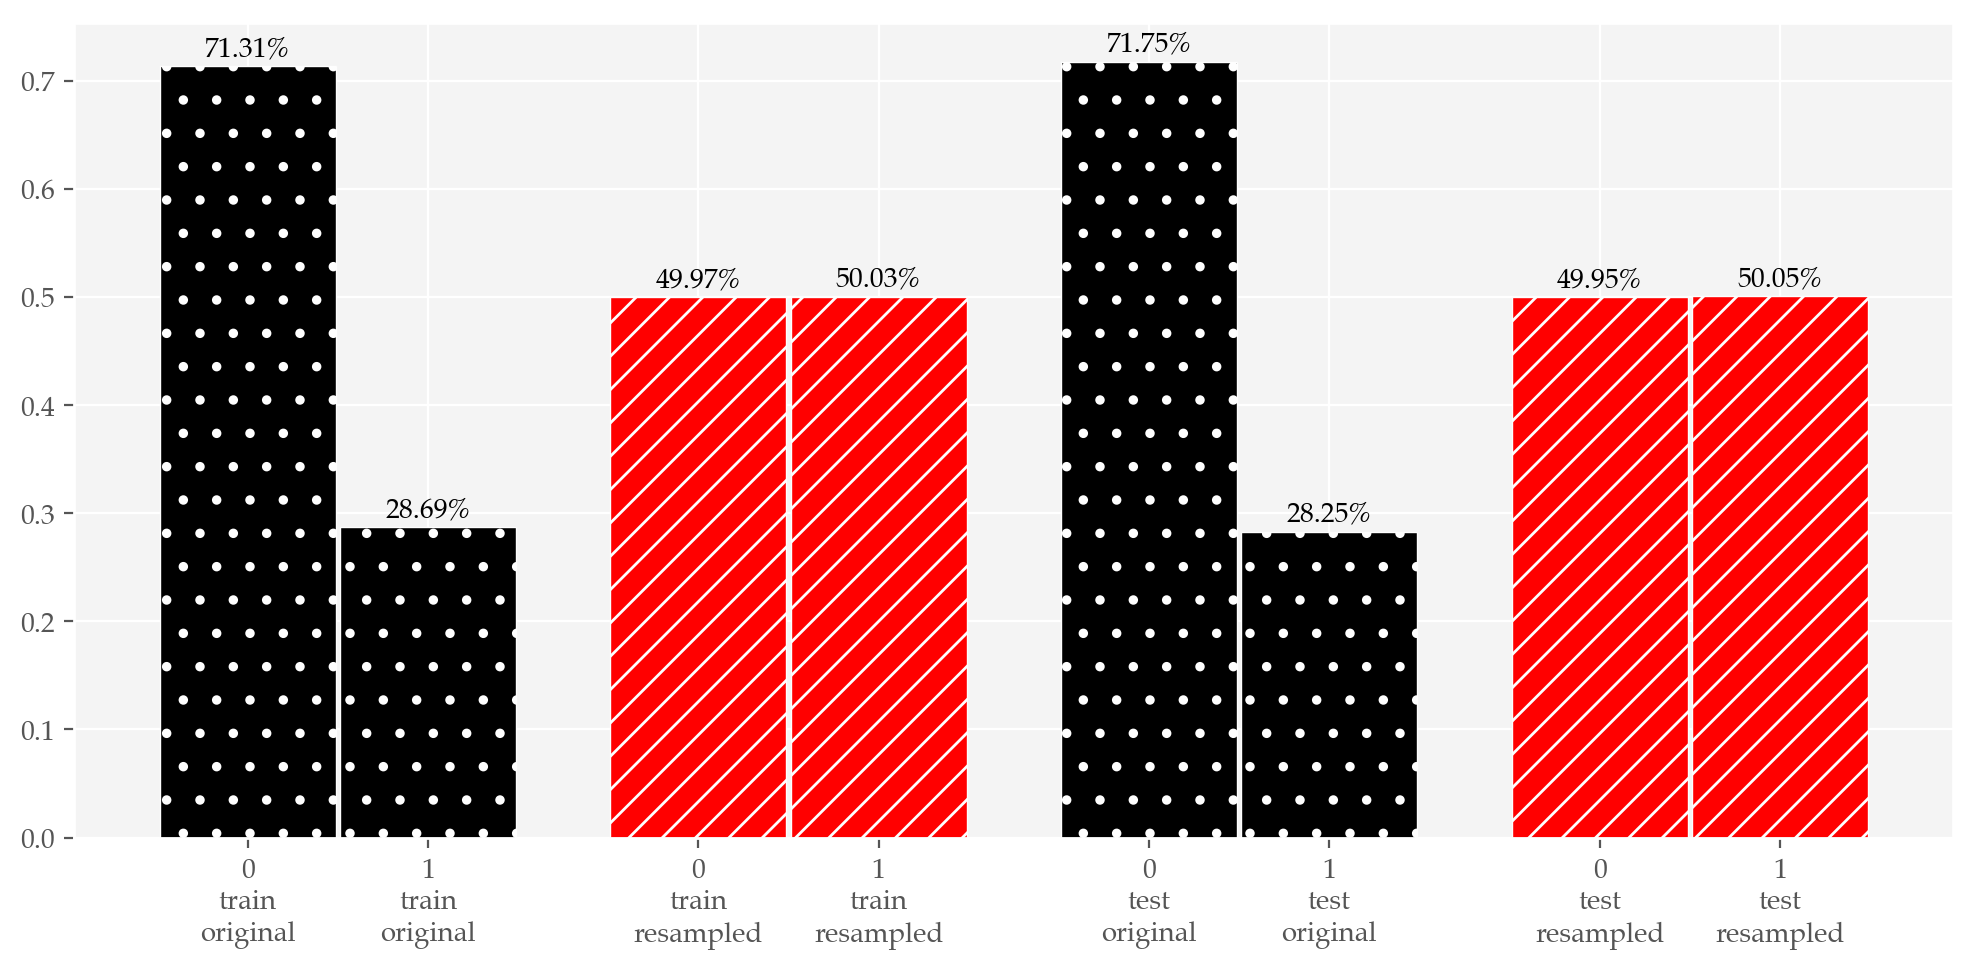

In [576]:
val_split = .2
sampler = SMOTETomek(random_state=0)
val_len = round(min(max_len, len(y)) * val_split)
y_train = y[:-val_len]
X_train = X[:-val_len]
y_test = y[-val_len:]
X_test = X[-val_len:]

r1_train = np.array(list(Counter(y_train).values())) / len(y_train)
r1_test = np.array(list(Counter(y_test).values())) / len(y_test)

X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)

BATCH_SIZE = 10
X_train, y_train = X_train[X_train.shape[0] % BATCH_SIZE:], y_train[y_train.shape[0] % BATCH_SIZE:]
X_test, y_test = X_test[X_test.shape[0] % BATCH_SIZE:], y_test[y_test.shape[0] % BATCH_SIZE:]

# plt.plot(range(len(y_train) // 10), y_train[::10])
# plt.show()

r2_train = np.array(list(Counter(y_train).values())) / len(y_train)
r2_test = np.array(list(Counter(y_test).values())) / len(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar([0.0, 0.2], r1_train, hatch='.', edgecolor='#fefefe', width=.195, color='k')
ax.bar([0.5, 0.7], r2_train, hatch='//', edgecolor='#fefefe', width=.195, color='r')
ax.bar([1.0, 1.2], r1_test,  hatch='.', edgecolor='#fefefe', width=.195, color='k')
ax.bar([1.5, 1.7], r2_test,  hatch='//', edgecolor='#fefefe', width=.195, color='r')
ax.set_xticklabels(['0\ntrain\noriginal', '1\ntrain\noriginal', '0\ntrain\nresampled', '1\ntrain\nresampled',
                    '0\ntest\noriginal', '1\ntest\noriginal', '0\ntest\nresampled', '1\ntest\nresampled'])
ax.set_xticks([0, 0.2, 0.5, 0.7, 1, 1.2, 1.5, 1.7])
ax.text(0.0, r1_train[0] + .01, '{:.2f}%'.format(r1_train[0] * 100), ha='center')
ax.text(0.2, r1_train[1] + .01, '{:.2f}%'.format(r1_train[1] * 100), ha='center')
ax.text(0.5, r2_train[0] + .01, '{:.2f}%'.format(r2_train[0] * 100), ha='center')
ax.text(0.7, r2_train[1] + .01, '{:.2f}%'.format(r2_train[1] * 100), ha='center')
ax.text(1.0, r1_test[0] + .01, '{:.2f}%'.format(r1_test[0] * 100), ha='center')
ax.text(1.2, r1_test[1] + .01, '{:.2f}%'.format(r1_test[1] * 100), ha='center')
ax.text(1.5, r2_test[0] + .01, '{:.2f}%'.format(r2_test[0] * 100), ha='center')
ax.text(1.7, r2_test[1] + .01, '{:.2f}%'.format(r2_test[1] * 100), ha='center')
plt.tight_layout()
plt.show()

#### Start training

In [502]:
seed = 123
scoring = 'accuracy'
num_features = min(max_features, len(features))
kfold = KFold(n_splits=5, random_state=123)

### 1. Hyper-parameter tuning

In [503]:
estimator_list = []
estimator_name_list = []
best_score_list = []
best_params_list = []
yhat_list = []

#### Logistic Regression

In [504]:
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'penalty': ['l1', 'l2'],
                                   'C': [1e-3, 1e-2, 1, 10, 100, 1000]})
lr_grid.fit(X_train, y_train)
print(lr_grid.best_score_, lr_grid.best_params_)
estimator_name_list.append('LR')
estimator_list.append(LogisticRegression)
best_score_list.append(lr_grid.best_score_)
best_params_list.append(lr_grid.best_params_)
yhat_list.append(lr_grid.predict(X_train))

0.4085747392815759 {'C': 0.001, 'penalty': 'l1'}


#### Linear Discriminant Analysis

In [505]:
lda_grid = GridSearchCV(estimator=LinearDiscriminantAnalysis(), cv=kfold, scoring=scoring,
                        param_grid={'solver': ['svd', 'lsqr'],
                                    'n_components': [None, 5, 10, 25]})
lda_grid.fit(X_train, y_train)
print(lda_grid.best_score_, lda_grid.best_params_)
estimator_name_list.append('LDA')
estimator_list.append(LinearDiscriminantAnalysis)
best_score_list.append(lda_grid.best_score_)
best_params_list.append(lda_grid.best_params_)
yhat_list.append(lda_grid.predict(X_train))

0.24634994206257244 {'n_components': None, 'solver': 'svd'}


#### Decision Tree

In [506]:
dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'criterion': ['gini', 'entropy'],
                                   'max_depth': [None, 5, 10, 25],
                                   'max_features': [None, 'auto', num_features // 2]})
dt_grid.fit(X_train, y_train)
print(dt_grid.best_score_, dt_grid.best_params_)
estimator_name_list.append('DT')
estimator_list.append(DecisionTreeClassifier)
best_score_list.append(dt_grid.best_score_)
best_params_list.append(dt_grid.best_params_)
yhat_list.append(dt_grid.predict(X_train))

0.5879490150637312 {'criterion': 'gini', 'max_depth': None, 'max_features': None}


#### KNN

In [507]:
knn_grid = GridSearchCV(estimator=KNeighborsClassifier(), cv=kfold, scoring=scoring,
                        param_grid={'n_neighbors': [5, 25, 100],
                                    'leaf_size': [2, 25, 100],
                                    'p': [2]})
knn_grid.fit(X_train, y_train)
print(knn_grid.best_score_, knn_grid.best_params_)
estimator_name_list.append('KNN')
estimator_list.append(KNeighborsClassifier)
best_score_list.append(knn_grid.best_score_)
best_params_list.append(knn_grid.best_params_)
yhat_list.append(knn_grid.predict(X_train))

0.4818076477404403 {'leaf_size': 2, 'n_neighbors': 5, 'p': 2}


#### Random Forest

In [508]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                       param_grid={'n_estimators': [100, 200],
                                   'criterion': ['gini', 'entropy'],
                                   'max_features': [None, num_features // 2],
                                   'max_depth': [5, 10, 25],
                                   'bootstrap': [True]})
rf_grid.fit(X_train, y_train)
print(rf_grid.best_score_, rf_grid.best_params_)
estimator_name_list.append('RF')
estimator_list.append(RandomForestClassifier)
best_score_list.append(rf_grid.best_score_)
best_params_list.append(rf_grid.best_params_)
yhat_list.append(rf_grid.predict(X_train))

0.5902665121668598 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 25, 'max_features': None, 'n_estimators': 200}


#### Extra Trees

In [509]:
ext_grid = GridSearchCV(estimator=ExtraTreesClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'criterion': ['gini', 'entropy'],
                                    'max_features': [None, num_features // 2],
                                    'max_depth': [5, 10, 25],
                                    'bootstrap': [True]})
ext_grid.fit(X_train, y_train)
print(ext_grid.best_score_, ext_grid.best_params_)
estimator_name_list.append('EXT')
estimator_list.append(ExtraTreesClassifier)
best_score_list.append(ext_grid.best_score_)
best_params_list.append(ext_grid.best_params_)
yhat_list.append(ext_grid.predict(X_train))

0.47253765932792585 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 25, 'max_features': None, 'n_estimators': 200}


#### AdaBoost

In [510]:
ada_grid = GridSearchCV(estimator=AdaBoostClassifier(random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                                    'n_estimators': [100, 200],
                                    'learning_rate': [1e-3, 1e-2]})
ada_grid.fit(X_train, y_train)
print(ada_grid.best_score_, ada_grid.best_params_)
estimator_name_list.append('ADA')
estimator_list.append(AdaBoostClassifier)
best_score_list.append(ada_grid.best_score_)
best_params_list.append(ada_grid.best_params_)
yhat_list.append(ada_grid.predict(X_train))

0.4353418308227115 {'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 100}


#### Gradient Boosting

In [511]:
gbm_grid = GridSearchCV(estimator=GradientBoostingClassifier(warm_start=True, random_state=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'max_depth': [5, 10, 25],
                                    'max_features': [None, num_features // 2],
                                    'learning_rate': [1e-3, 1e-2]})
gbm_grid.fit(X_train, y_train)
print(gbm_grid.best_score_, gbm_grid.best_params_)
estimator_name_list.append('GBM')
estimator_list.append(GradientBoostingClassifier)
best_score_list.append(gbm_grid.best_score_)
best_params_list.append(gbm_grid.best_params_)
yhat_list.append(gbm_grid.predict(X_train))

0.5845886442641947 {'learning_rate': 0.01, 'max_depth': 25, 'max_features': None, 'n_estimators': 200}


#### XGBoost

In [512]:
set_start_method('forkserver', force=True)  # manually enable multithreading
xgb_grid = GridSearchCV(estimator=XGBClassifier(n_jobs=4, seed=seed), cv=kfold, scoring=scoring,
                        param_grid={'n_estimators': [100, 200],
                                    'max_depth': [5, 10, 25],
                                    'min_child_weight': [1, 5],
                                    'gamma': [0, 0.1, 1, 10],
                                    'learning_rate': [1e-3, 1e-2]})
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_score_, xgb_grid.best_params_)
estimator_name_list.append('XGB')
estimator_list.append(XGBClassifier)
best_score_list.append(xgb_grid.best_score_)
best_params_list.append(xgb_grid.best_params_)
yhat_list.append(xgb_grid.predict(X_train))

0.5944380069524913 {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 25, 'min_child_weight': 1, 'n_estimators': 200}


#### SVC

In [513]:
svc_grid = GridSearchCV(estimator=SVC(probability=True, class_weight='balanced'), cv=kfold, scoring=scoring,
                        param_grid={'C': [1e-3, 1e-2, 1e-1, 1, 10],
                                    'gamma': [1e-2, 1e-1, 1]})
svc_grid.fit(X_train, y_train)
print(svc_grid.best_score_, svc_grid.best_params_)
estimator_name_list.append('SVC')
estimator_list.append(SVC)
best_score_list.append(svc_grid.best_score_)
best_params_list.append(svc_grid.best_params_)
yhat_list.append(svc_grid.predict(X_train))

0.5803012746234067 {'C': 0.01, 'gamma': 1}


### 2. What about LSTM?

There are in total 7233 parameters and 4 hidden layers in this LSTM network:
- Layer 0 (LSTM): 6144
- Layer 1 (Dropout): 0
- Layer 2 (Tanh): 1056
- Layer 3 (Output): 33

Epoch 30/30 |#####################| - eta: 0s - loss: 1.2147 - val_loss: 1.2189 - acc: 0.4598 - val_acc: 0.4651                                       


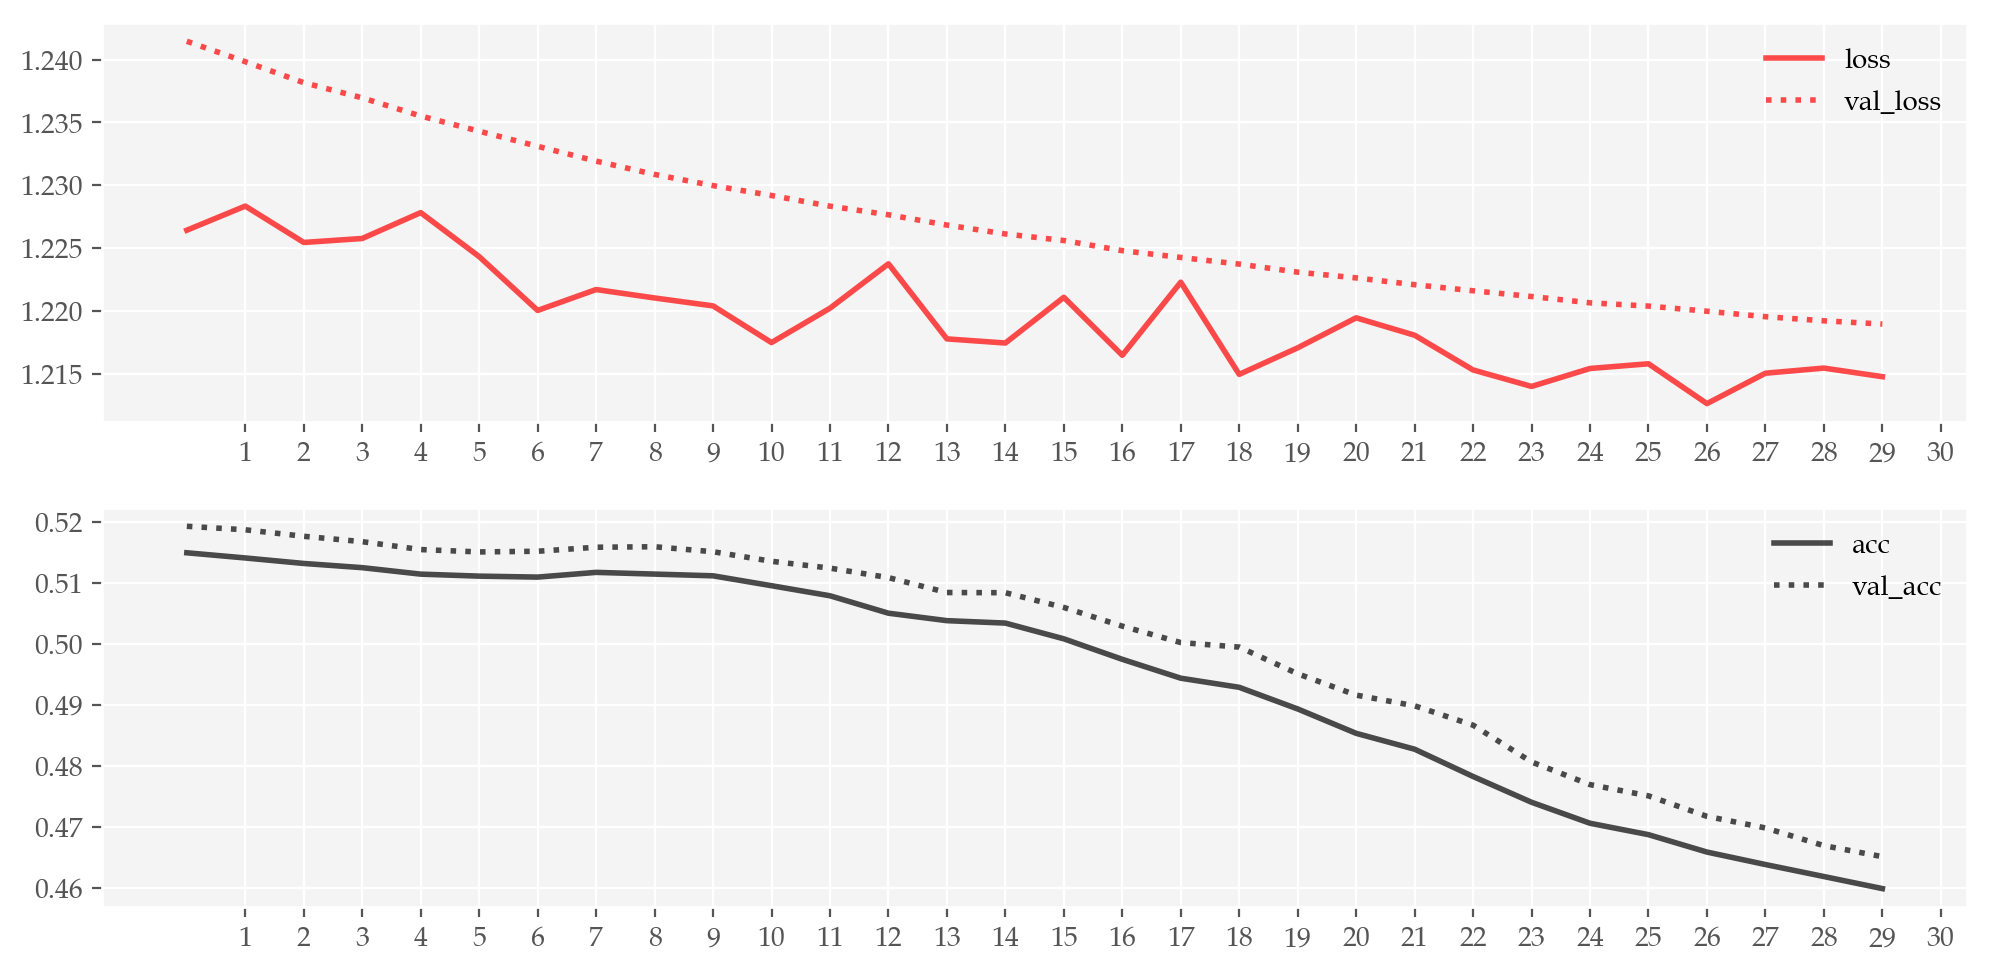

In [590]:
batch_size = BATCH_SIZE
epochs = 30
neurons = 32

X_train_seq = X[:-val_len]                            # data is not shuffled for LSTM
y_train_seq = (df.dcs.shift(-forecast) / df.dcs.std())[:-val_len]  # y is before cat and normed
lt = len(y_train_seq)  # length of training set
cv_val_len = int(lt * val_split)
idx = np.arange(lt)
nfolds = int(1 / val_split)

np.random.seed(seed)
model = Sequential()
model.add(LSTM(neurons, stateful=True, batch_input_shape=(batch_size, 1, X_train.shape[1]), name='LSTM'))
model.add(Dropout(.2, name='Dropout'))
model.add(Dense(neurons, activation='tanh', name='Tanh'))
model.add(Dense(1, name='Output'))
nl = len(model.layers)
print(f'There are in total {model.count_params()} parameters and {nl} hidden layers in this LSTM network:')
for i in range(nl):
    print(f'- Layer {i} ({model.layers[i].name}): {model.layers[i].count_params()}')
print()
model.compile(loss='mse', optimizer=Adadelta(lr=1e-3))

history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
t0 = time.time()
width = 20
rightarrow, blacksquare, whitesquare = '>', '#', '='
cat = np.vectorize(cat)

for i in range(epochs):
    loss, val_loss, acc, val_acc = 0, 0, 0, 0
    for j in range(nfolds):
        mask = np.logical_and(idx >= j * cv_val_len, idx < (j + 1) * cv_val_len)
        X_train_lstm, y_train_lstm = X_train_seq[~mask], y_train_seq[~mask]
        X_test_lstm, y_test_lstm = X_train_seq[mask], y_train_seq[mask]
        X_train_lstm = X_train_lstm[X_train_lstm.shape[0] % BATCH_SIZE:]  # training length should be xBATCH_SIZE
        y_train_lstm = y_train_lstm[y_train_lstm.shape[0] % BATCH_SIZE:]  # training length should be xBATCH_SIZE
        X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1])  # reshape X
        X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], 1, X_test_lstm.shape[1])      # reshape X
        # print(X_train_lstm.shape, X_test_lstm.shape)
        model.fit(X_train_lstm, y_train_lstm, epochs=1, batch_size=batch_size,
                  validation_data=(X_test_lstm, y_test_lstm), verbose=0)
        loss += model.history.history['loss'][0]
        val_loss += model.history.history['val_loss'][0]
        y_train_lstm_hat = cat(model.predict(X_train_lstm, batch_size=batch_size))
        y_train_lstm = cat(y_train_lstm)
        acc += (y_train_lstm == y_train_lstm_hat).mean()
        y_test_lstm_hat = cat(model.predict(X_test_lstm, batch_size=batch_size))
        y_test_lstm = cat(y_test_lstm)
        val_acc += (y_test_lstm == y_test_lstm_hat).mean()

    loss /= nfolds
    val_loss /= nfolds
    acc /= nfolds
    val_acc /= nfolds

    dt = time.time() - t0
    progress = (i + 1) / epochs
    eta = dt / progress * (1 - progress)
    nbars = round(width * progress)
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(acc)
    history['val_acc'].append(val_acc)
    msg1 = 'Epoch {}/{} |{}{}{}| - eta: {:.0f}s'.\
    format(i + 1, epochs, blacksquare * nbars, rightarrow, whitesquare * (width - nbars - 1), eta)
    msg2 = 'loss: {:.4f} - val_loss: {:.4f} - acc: {:.4f} - val_acc: {:.4f}'.\
    format(loss, val_loss, acc, val_acc)
    msg = msg1 + ' - ' + msg2
    print('{: <150s}'.format(msg), end='\r')

print(msg.replace(rightarrow, blacksquare))

fig = plt.figure()
ax = fig.add_subplot(211)
ax.plot(history['loss'], 'r', alpha=.7, label='loss')
ax.plot(history['val_loss'], 'r:', alpha=.7, label='val_loss')
ax.set_xticks(np.arange(epochs) + 1)
ax.legend(frameon=False)
ax = fig.add_subplot(212)
ax.plot(history['acc'], 'k', alpha=.7, label='acc')
ax.plot(history['val_acc'], 'k:', alpha=.7, label='val_acc')
ax.set_xticks(np.arange(epochs) + 1)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# best_score_list = best_score_list[:-1]
# estimator_list = estimator_list[:-1]
# estimator_name_list = estimator_name_list[:-1]
# best_params_list = best_params_list[:-1]
# yhat_list = yhat_list[:-1]

In [522]:
best_score_list.append(history['val_acc'][-1])
estimator_list.append(model)
estimator_name_list.append('LSTM')
best_params_list.append(None)
yhat_list.append(model.predict_classes(
    X_train.reshape(X_train.shape[0], 1, X_train.shape[1]),
    batch_size=batch_size).T[0])

### 7. Ensemble and Out-of-Sample Validation

First let's try voting (weighted on scores).

In [523]:
seq = sorted(best_score_list, reverse=True)

res = pd.DataFrame({'model':estimator_name_list, 'score':best_score_list},
                   columns=['model', 'score']).set_index('model')
res['weight'] = (res['score'] - res['score'].min()) / (res['score'].max() - res['score'].min())
res['weight'] /= res['weight'].sum()
res_voting = res.copy()
res.round(3).T

model,LR,LDA,DT,KNN,RF,EXT,ADA,GBM,XGB,SVC,LSTM
score,0.409,0.246,0.588,0.482,0.590,0.473,0.435,0.585,0.594,0.580,0.713
weight,0.054,0.000,0.114,0.079,0.115,0.076,0.063,0.113,0.117,0.112,0.156


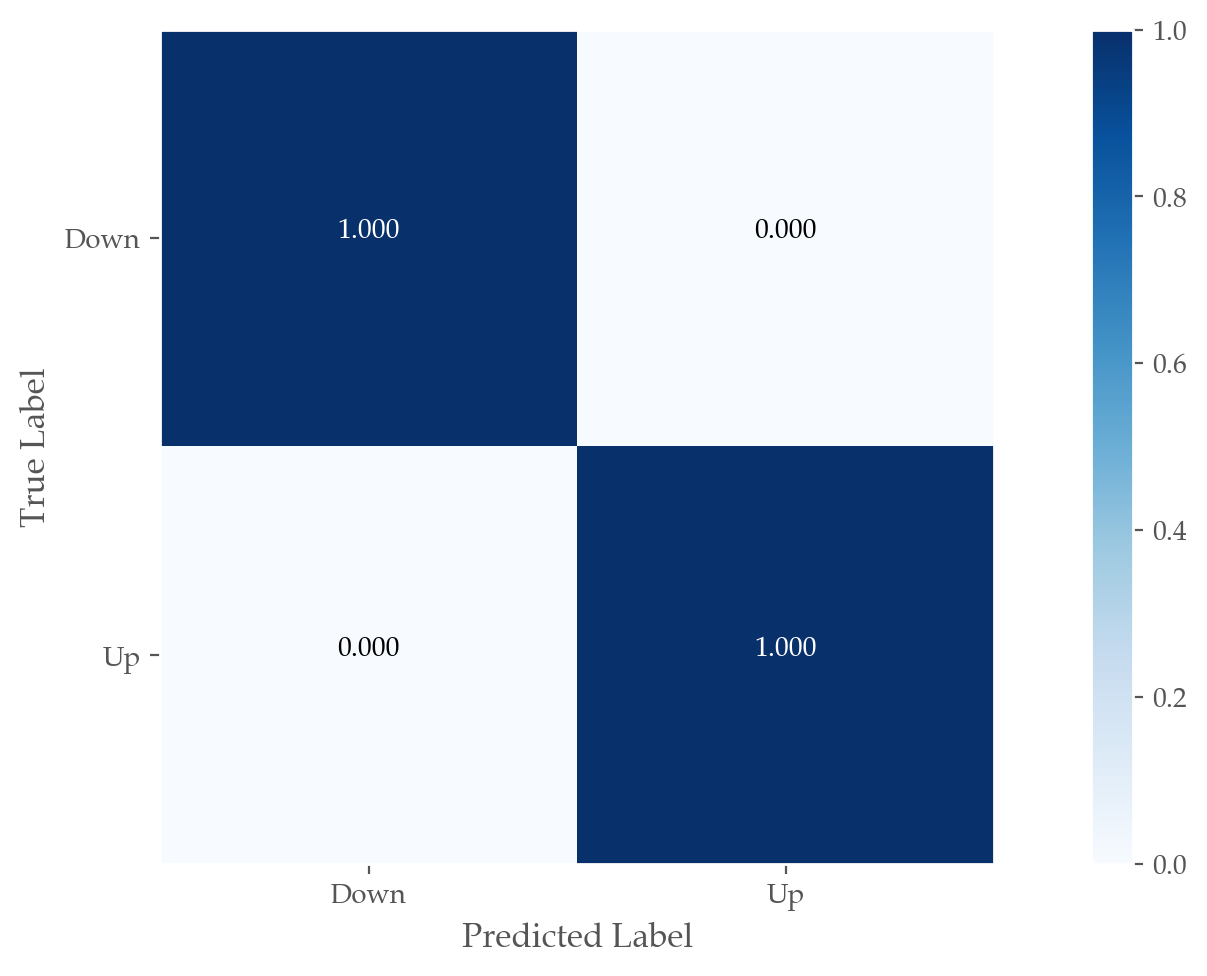

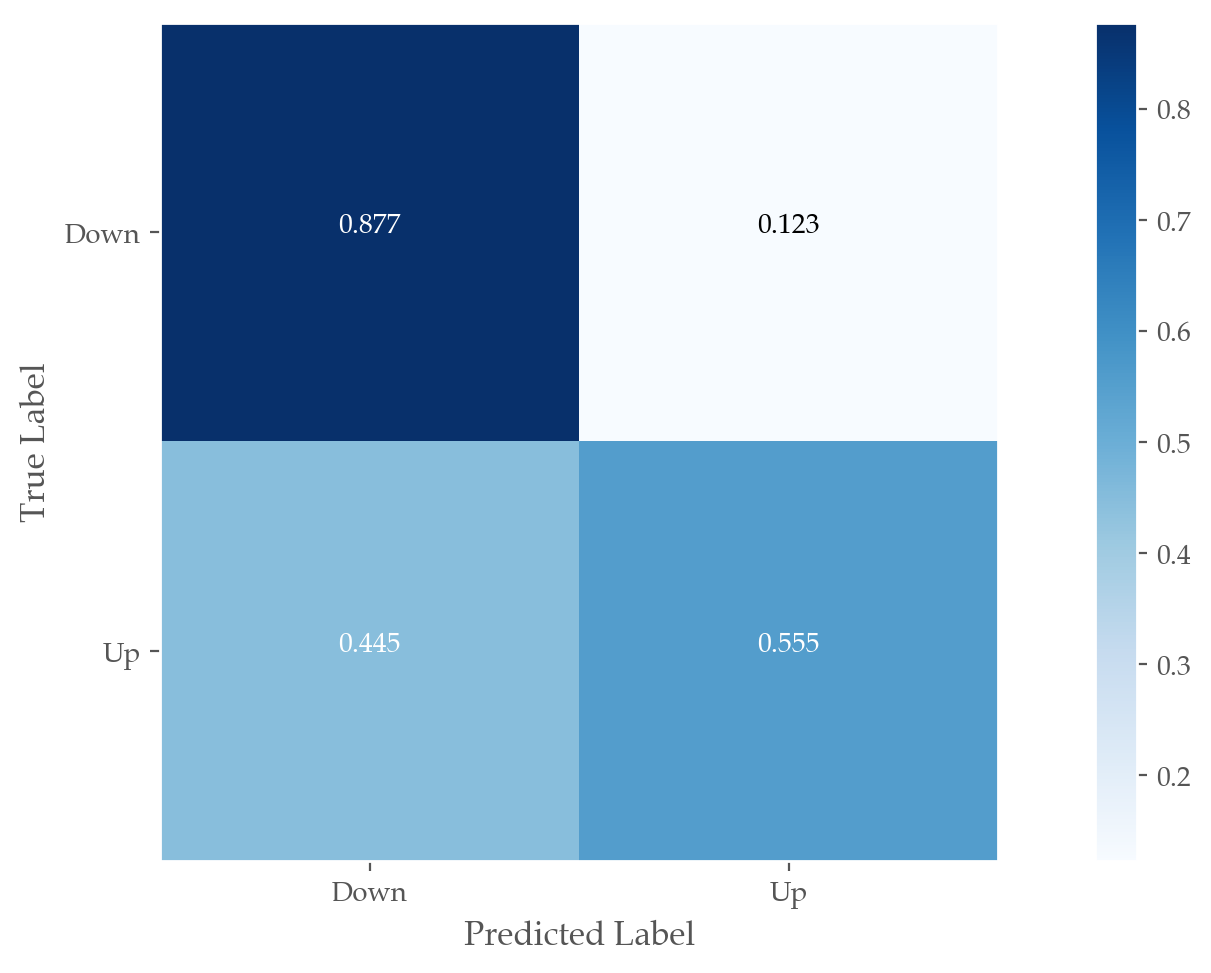

In [527]:
y_pred = {}  # only test

for name, est, params in zip(estimator_name_list, estimator_list, best_params_list):
    try:
        est = est(**params)
        est.fit(X_train, y_train)
        y_pred['y_hat_' + name] = est.predict(X_test)
    except TypeError:
        y_pred['y_pred_LSTM'] = model.predict_classes(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]),
                                                      batch_size=batch_size).T[0]

y_pred_individual = np.vstack(y_pred.values())
y_hat = np.average(np.vstack(yhat_list), axis=0, weights=res['weight']).round().astype('int')
y_pred = np.average(y_pred_individual, axis=0, weights=res['weight']).round().astype('int')
y_pred_voting = y_pred.copy()

plot_confusion_matrix(y_train, y_hat, ['Down', 'Up'], normalize=True)
plot_confusion_matrix(y_test, y_pred, ['Down', 'Up'], normalize=True)

Now we try stacking.

In [528]:
seq = sorted(best_score_list, reverse=True)

stack_grid = GridSearchCV(estimator=LogisticRegression(random_state=seed), cv=kfold, scoring=scoring,
                          param_grid={'penalty': ['l2'],  # L2 gives less sparse coef
                                      'C': [1e-3, 1e-2, 1, 10, 100, 1000]})
stack_grid.fit(np.vstack(yhat_list).T, y_train)
sclf = stack_grid.best_estimator_
weight = sclf.coef_.squeeze()
res = pd.DataFrame({'model':estimator_name_list, 'score':best_score_list, 'weight':weight},
                   columns=['model', 'score', 'weight']).set_index('model')
res_stacking = res.copy()
res.round(3).T

model,LR,LDA,DT,KNN,RF,EXT,ADA,GBM,XGB,SVC,LSTM
score,0.409,0.246,0.588,0.482,0.59,0.473,0.435,0.585,0.594,0.580,0.713
weight,0.000,-0.306,1.310,0.222,1.31,1.101,-0.203,1.310,1.217,-1.323,-0.001


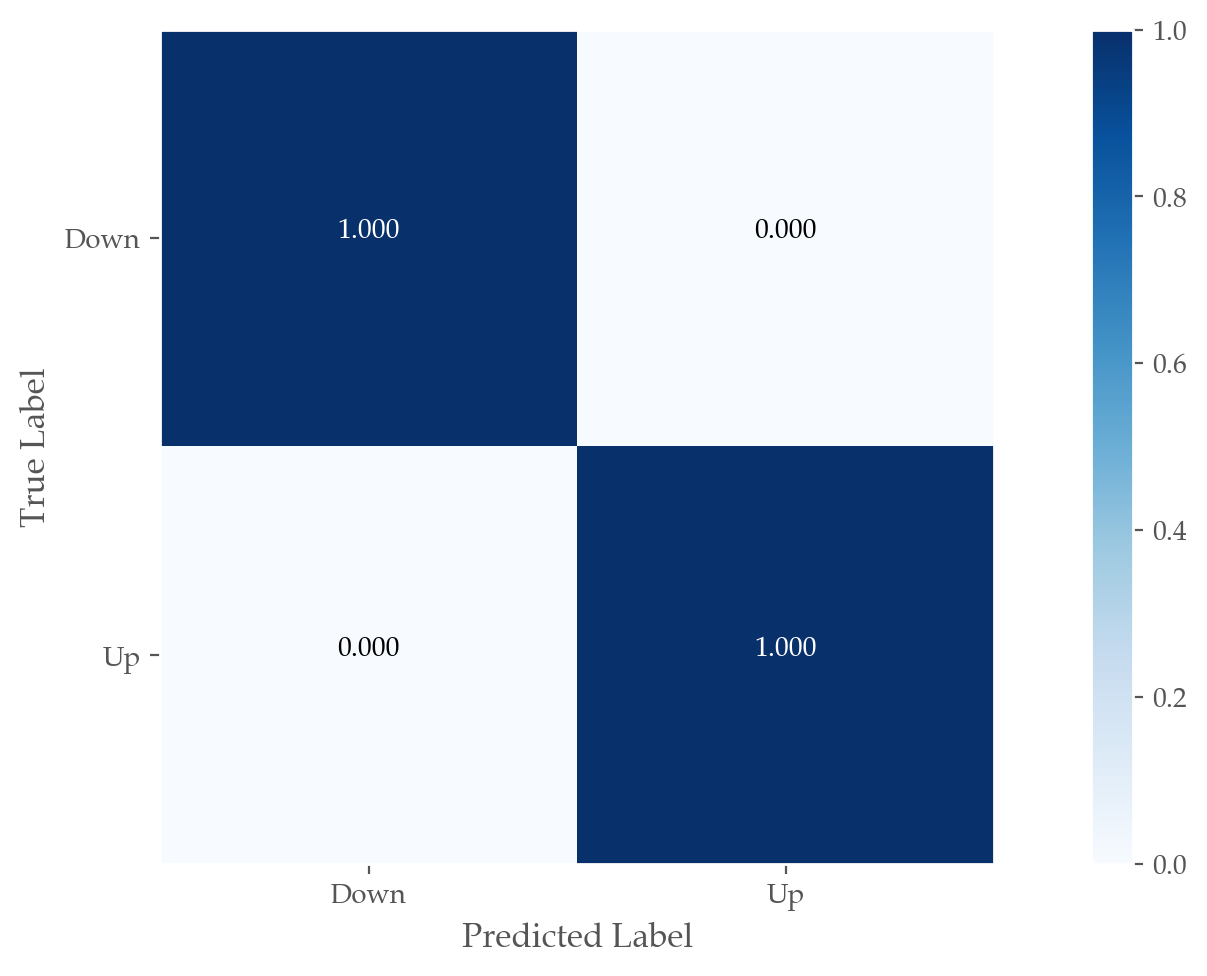

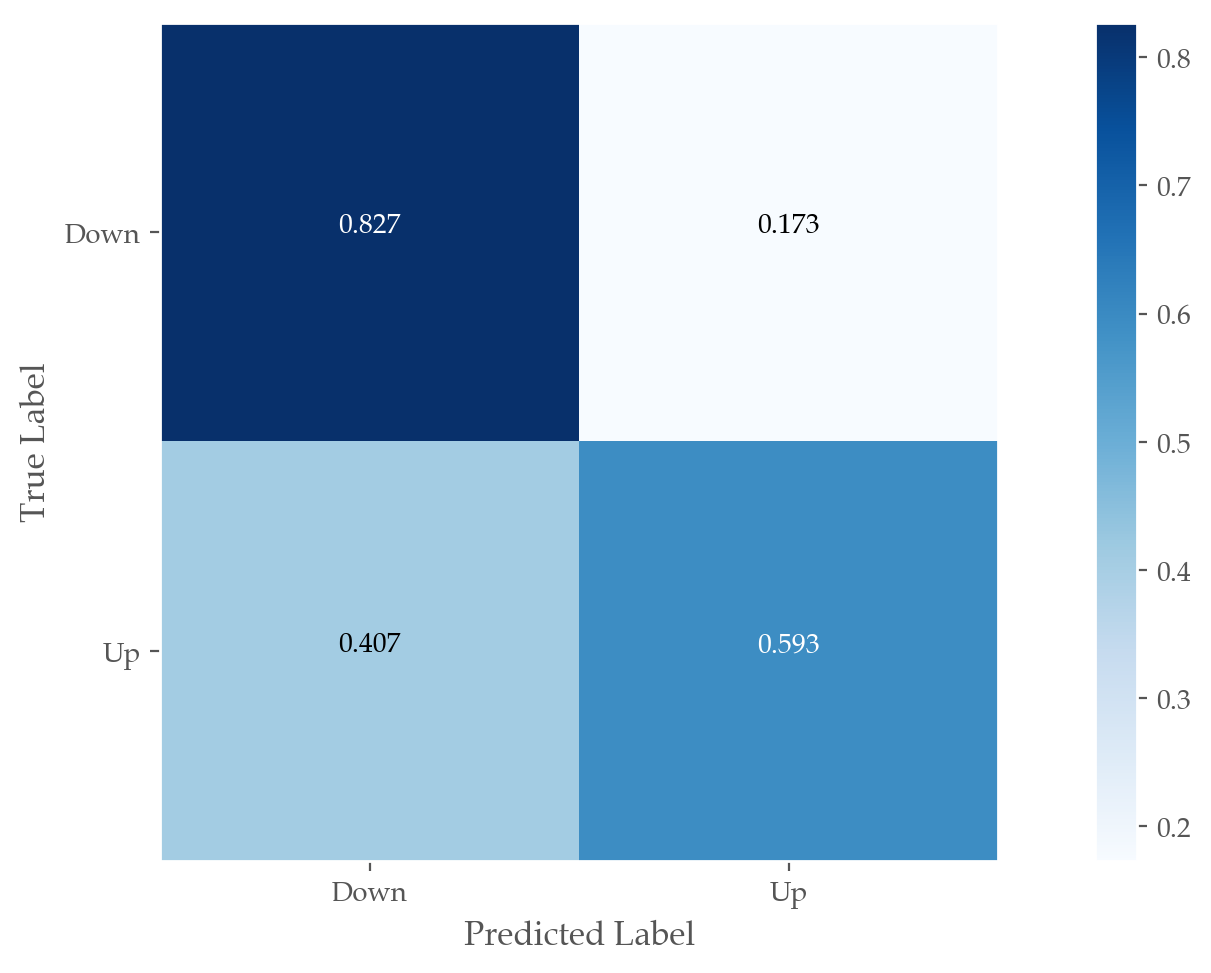

In [529]:
y_hat = stack_grid.predict(np.vstack(yhat_list).T)
y_pred = stack_grid.predict(y_pred_individual.T)
y_pred_stacking = y_pred.copy()

plot_confusion_matrix(y_train, y_hat, ['Down', 'Up'], normalize=True)
plot_confusion_matrix(y_test, y_pred, ['Down', 'Up'], normalize=True)

In [ ]:
HTML('''<script>initialize();</script>Click <a href="javascript:code_toggle()">here</a> to show/hide codes in this notebook. Click <a href="https://github.com/allenfrostline/iaqf2019/blob/master/explore.ipynb">here</a> to download this notebook.''')